# 21기 Clustering 정규세션 과제

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set_palette("Set2")
warnings.filterwarnings(action='ignore')
np.set_printoptions(formatter={'float': '{:0.6f}'.format})

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from itertools import combinations

## 0. 데이터 불러오기

In [141]:
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1. Preprocssing / EDA

In [44]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


➡️ 결측치 없음

In [45]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [46]:
df[df.duplicated()]

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,


In [142]:
# 이상치 개수 확인
def numeric_iqr (col) :
    q1 = df[col].quantile(q=0.25)
    q3 = df[col].quantile(q=0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)

    return outliers.sum()

numeric_col = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

for col in numeric_col :
    outliers = numeric_iqr (col)
    print(f"{col}의 이상치 비율: {round(outliers / df.shape[0] * 100,2)}%")

Age의 이상치 비율: 0.0%
Annual Income (k$)의 이상치 비율: 1.0%
Spending Score (1-100)의 이상치 비율: 0.0%


➡️ RobustScaler 사용 여부를 판단하기 위해 이상치 개수를 알아보았다. 그 결과 이상치가 없거나 매우 적은 것으로 확인된다.

In [143]:
# Gender 컬럼 레이블 인코딩
df['Gender'].replace({'Male':1, 'Female':0},inplace=True)

In [144]:
# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
scaled_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


### EDA

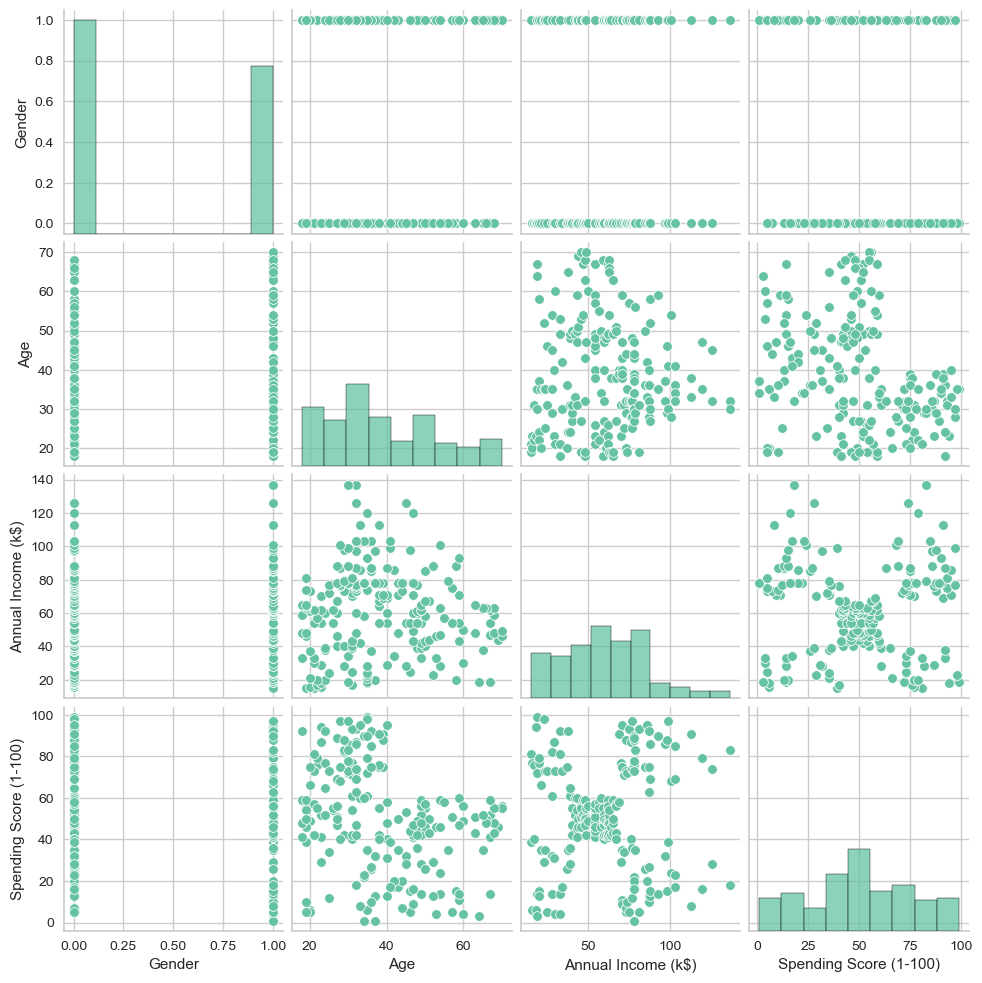

In [54]:
plot = sns.pairplot(df)
plt.show()

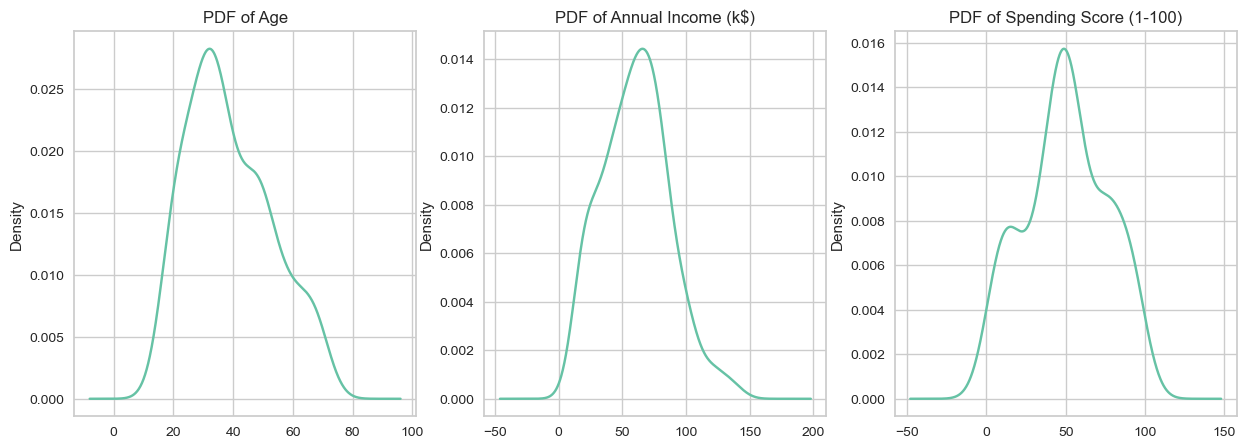

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cols =  [ 'Age', 'Annual Income (k$)','Spending Score (1-100)']
for i in range(3):
    df[cols[i]].plot.density(ax=axes[i])
    axes[i].set_title(f'PDF of {cols[i]}')
plt.show()

### 차원축소

In [146]:
pca = PCA()
pca_result = pca.fit_transform(scaled_df)
pca.explained_variance_ratio_

array([0.336900, 0.262306, 0.232606, 0.168187])

➡️ 3개의 주성분을 사용한다

In [148]:
pca = PCA(n_components = 3)
pca_result = pca.fit_transform(df)
pca_df = pd.DataFrame(pca.fit_transform(df), columns = ['PC1', 'PC2','PC3'])

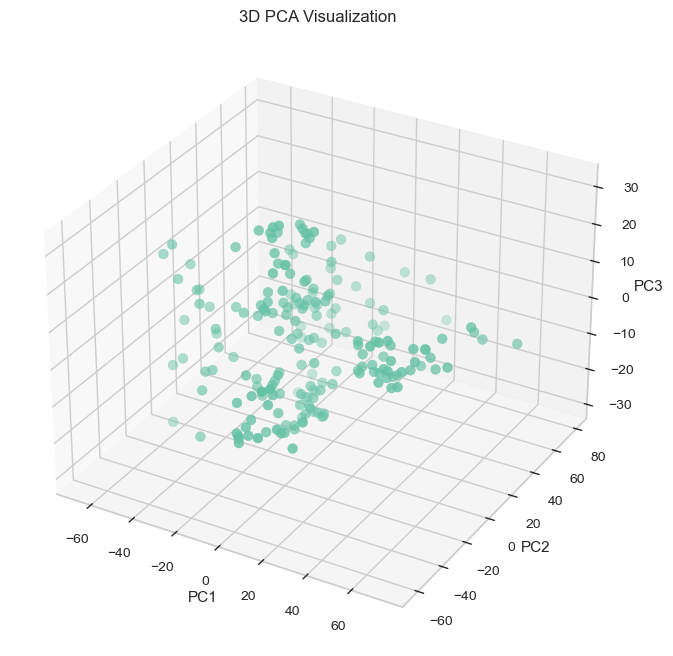

In [150]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.title('3D PCA Visualization')
plt.show()

## 2. Clustering  

In [162]:
numeric_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

def visualization (predictions) :
    df['Cluster'] = predictions
    col_combinations = combinations(numeric_cols, 2)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for ax, (x_col, y_col) in zip(axes.flatten(), col_combinations):
        for cluster in df['Cluster'].unique():
            cluster_data = df[df['Cluster'] == cluster]
            ax.scatter(cluster_data[x_col], cluster_data[y_col], label=f'Cluster {cluster}')
            
        ax.set_title(f'{x_col} vs {y_col}')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

### 2.1  Hierarchical Clustering - AgglomerativeClustering 

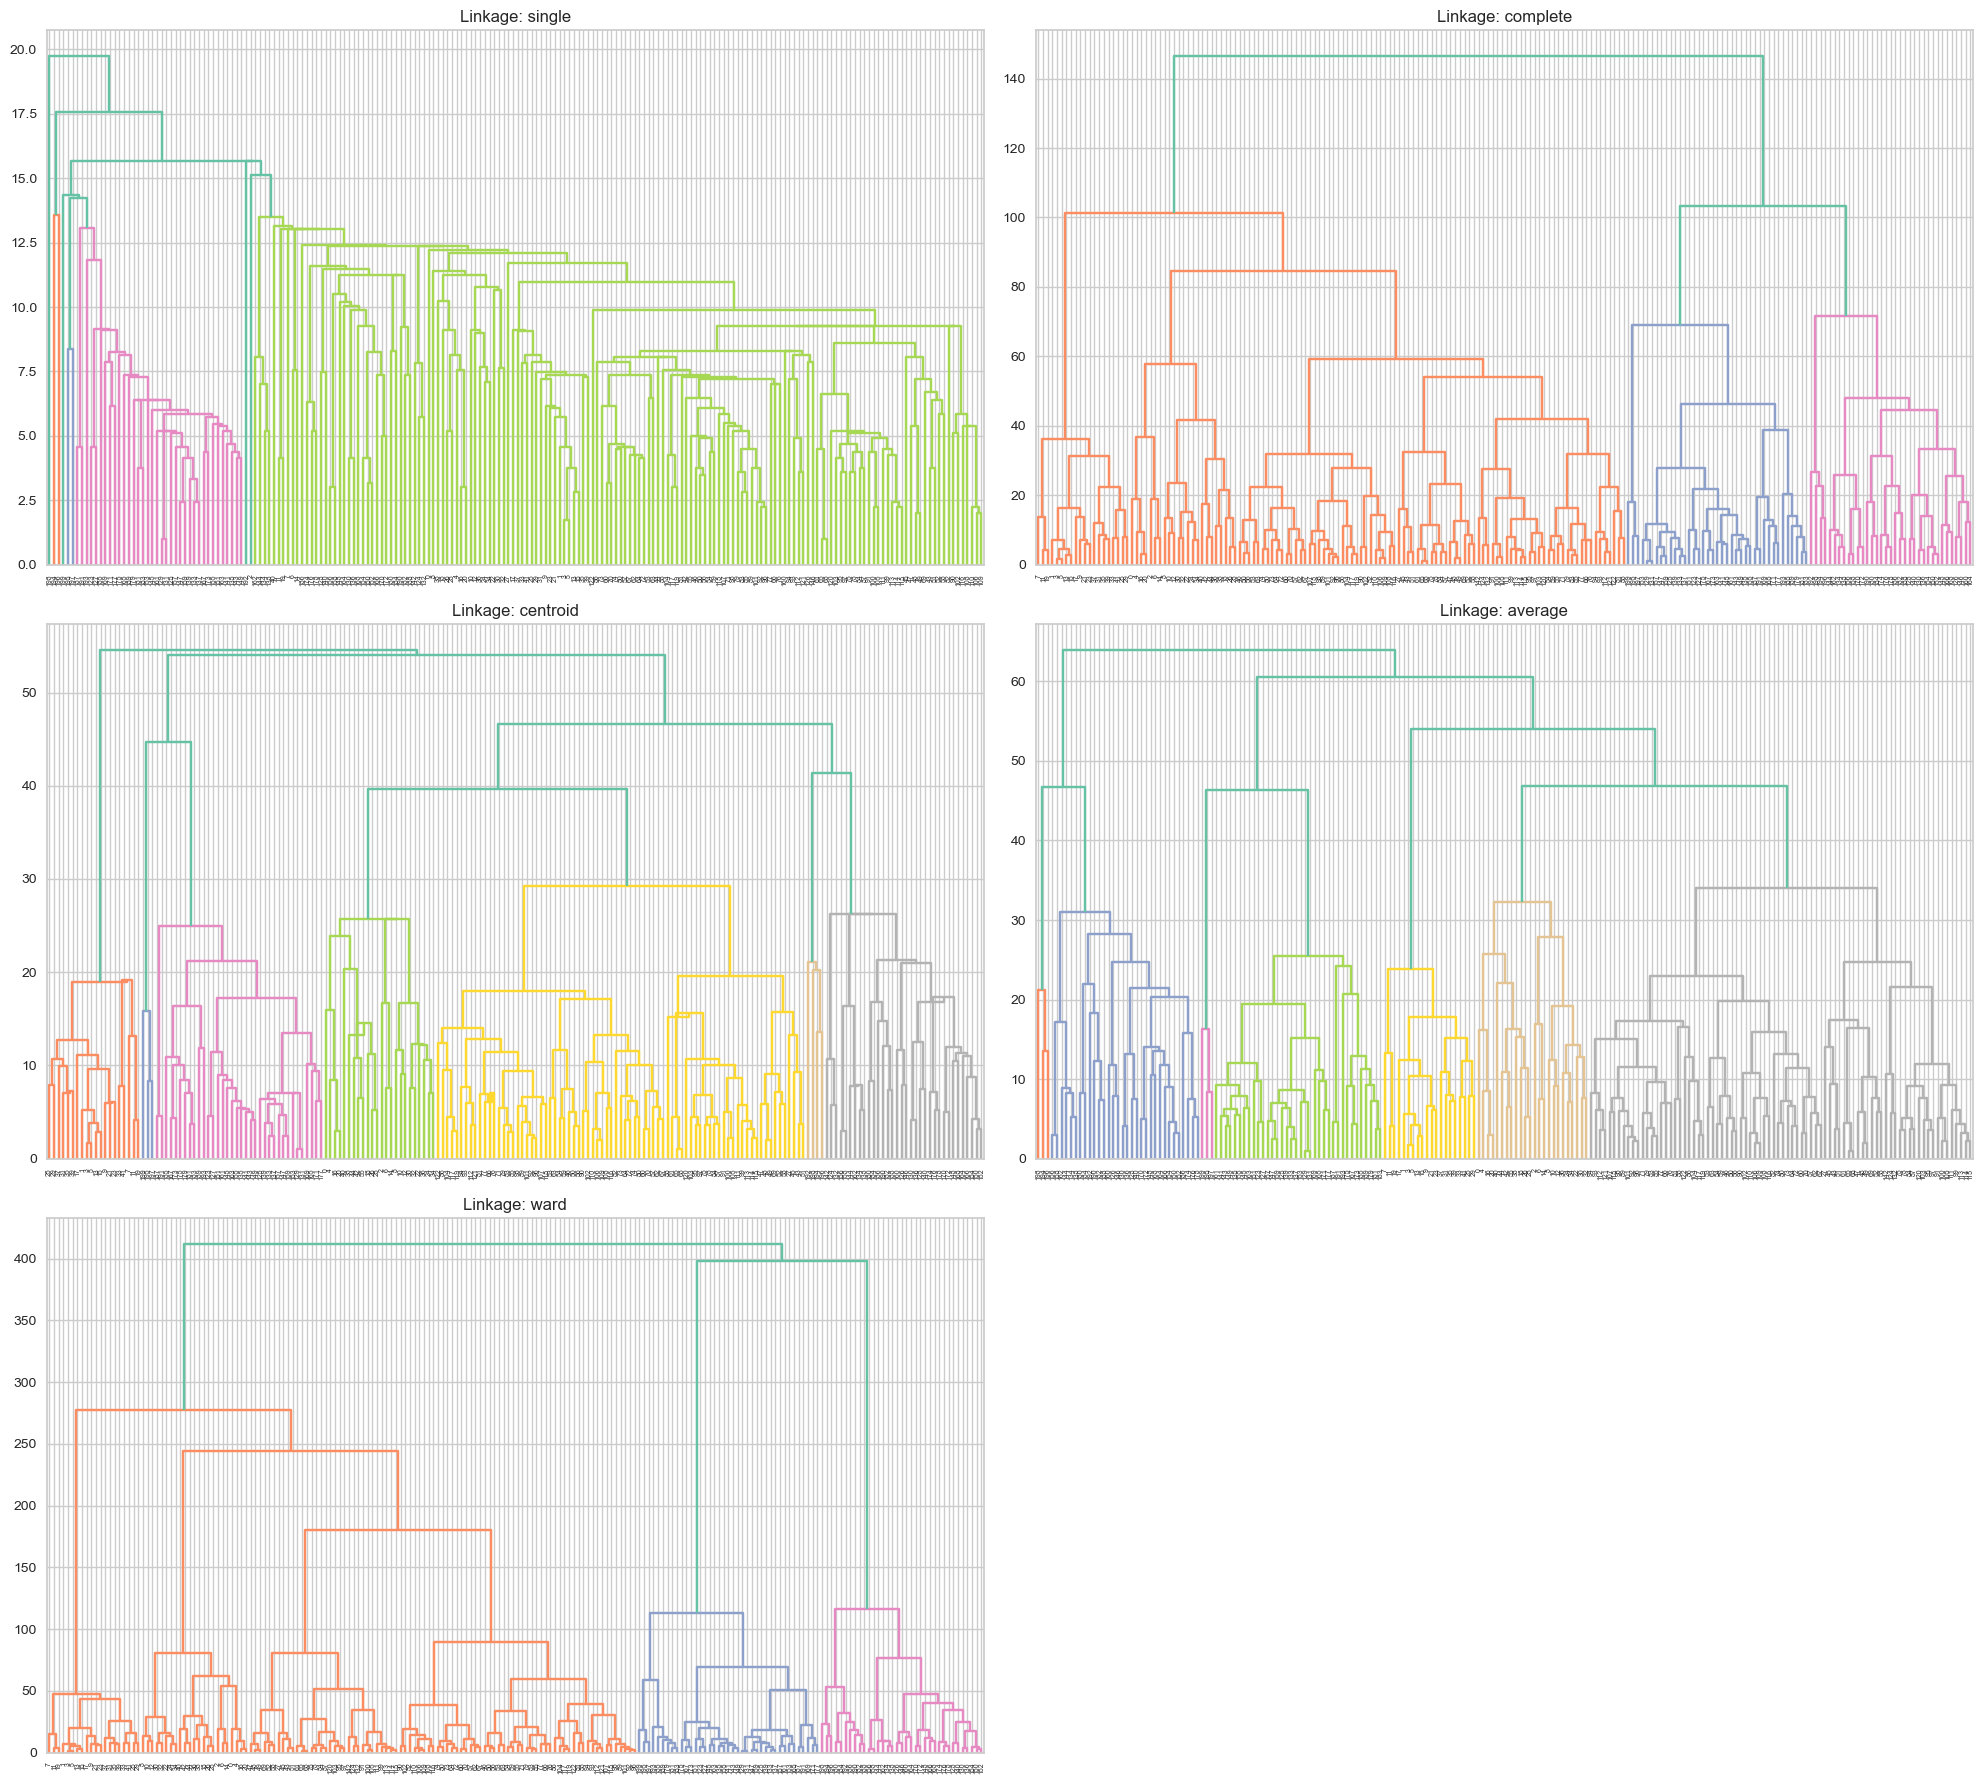

In [156]:
linkage_list = ['single', 'complete', 'centroid', 'average', 'ward']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
axes = axes.flatten()  

for i, method in enumerate(linkage_list):
    clustering = linkage(pca_df, method=method)
    dendrogram(clustering, ax=axes[i])
    axes[i].set_title(f'Linkage: {method}')

axes[-1].axis('off')

plt.tight_layout()
plt.show()

➡️ 군집 간 높이 차가 큰 군집의 개수를 선택하면, 군집 내 응집력이 높고 군집 간 이질성이 큰 결과를 얻을 수 있다. 시각화 결과에서 비교적 높이 차가 뚜렷하고 골고루 클러스터링된 세 가지 ['complete', 'average', 'ward'] linkage type에 대해서 실루엣 점수와 적절한 클러스터 개수를 산출하고자 한다.

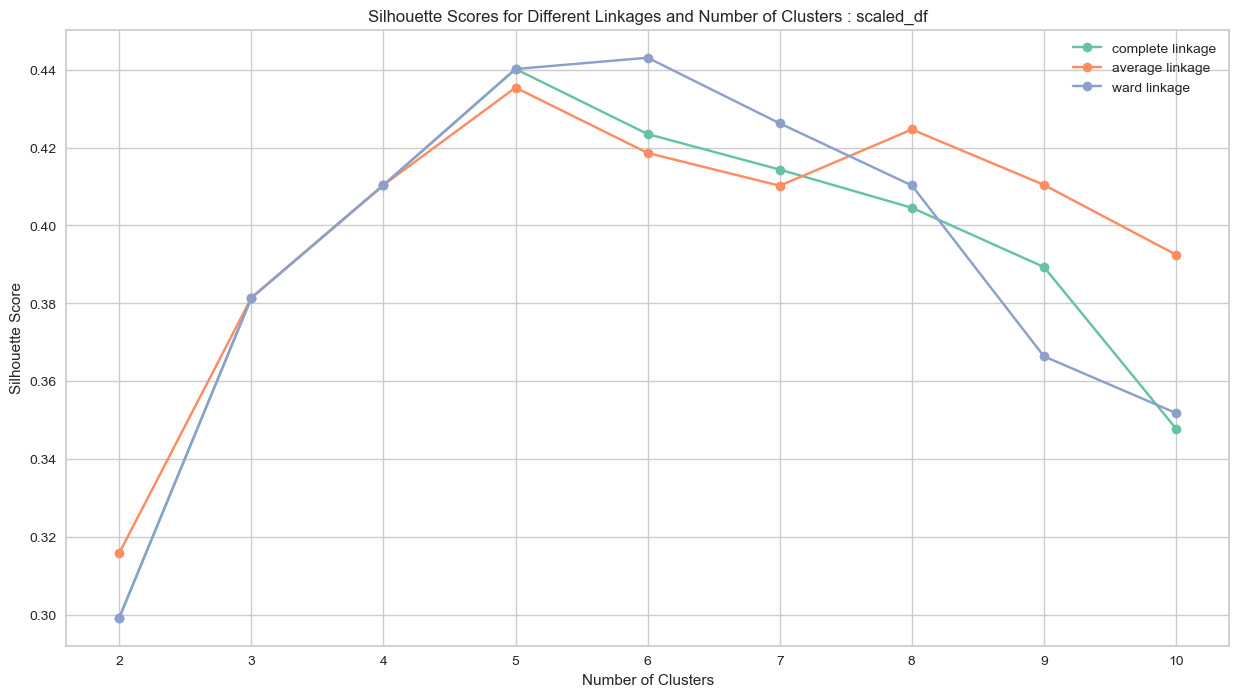

In [170]:
linkage_list = ['complete', 'average', 'ward']
n_clusters_range = [2,3,4,5,6,7,8,9,10]

# 실루엣 점수
silhouette_scores = {method: [] for method in linkage_list}  

for linkage in linkage_list:
    for n_clusters in n_clusters_range:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        cluster_labels = clustering.fit_predict(pca_df)
        
        score = silhouette_score(pca_df, cluster_labels)
        silhouette_scores[linkage].append(score)

# 시각화
plt.figure(figsize=(15, 8))
for linkage, scores in silhouette_scores.items():
    plt.plot(n_clusters_range, scores, marker='o', label=f'{linkage} linkage')

plt.title('Silhouette Scores for Different Linkages and Number of Clusters : scaled_df')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()


➡️ cluster 개수는 6이고, linkage type이 'ward'일 때 실루엣 점수가 가장 높다. cluster 개수가 5일 때의 실루엣 점수와 미세한 차이가 나타나므로 두 개의 클러스터 후보에 대해 군집 결과를 시각화하고자 한다.

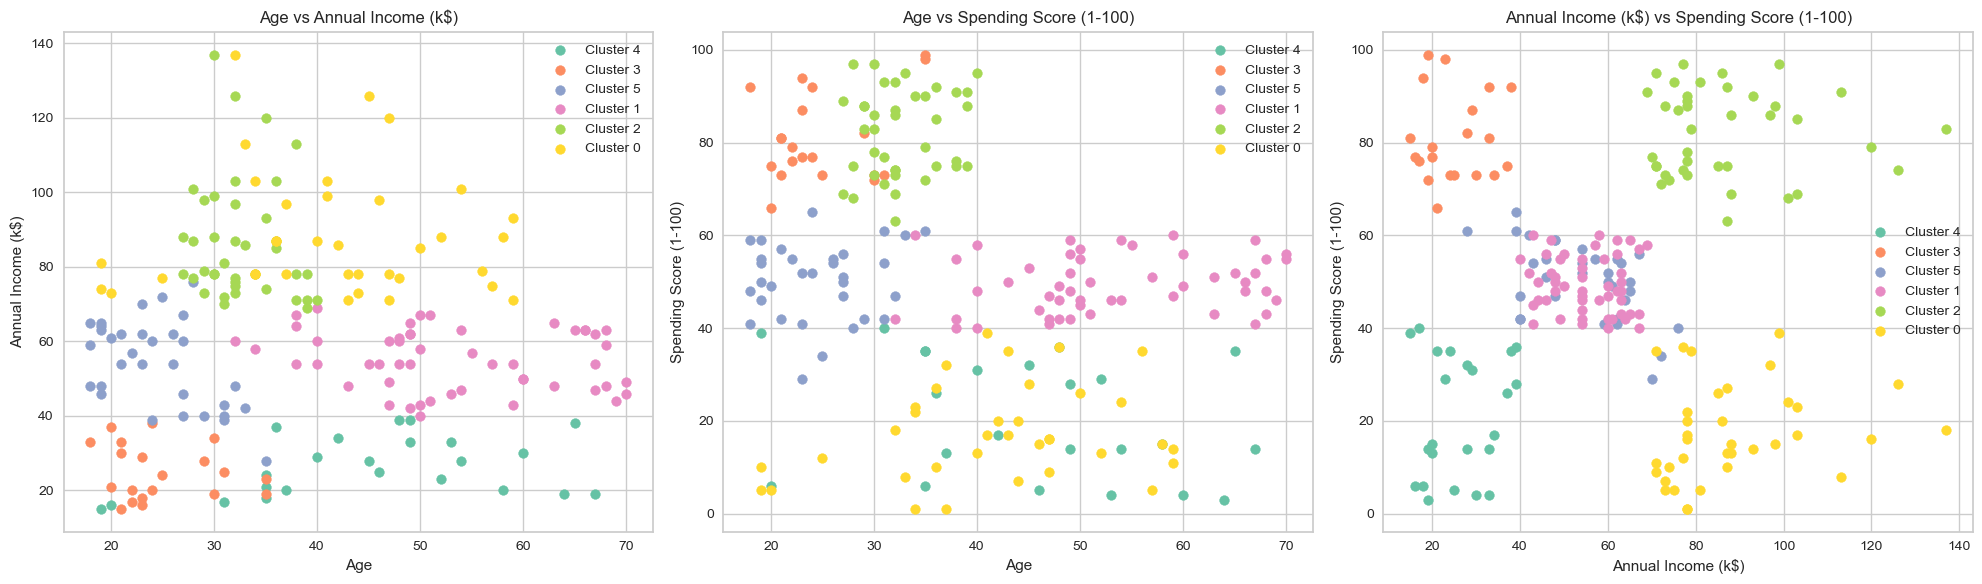

0.4430889630348533

In [216]:
agg = AgglomerativeClustering(n_clusters=6, linkage='ward')
agg_pred_6 = agg.fit_predict(pca_df)

visualization (agg_pred_6)
silhouette_score(pca_df, agg_pred_6)

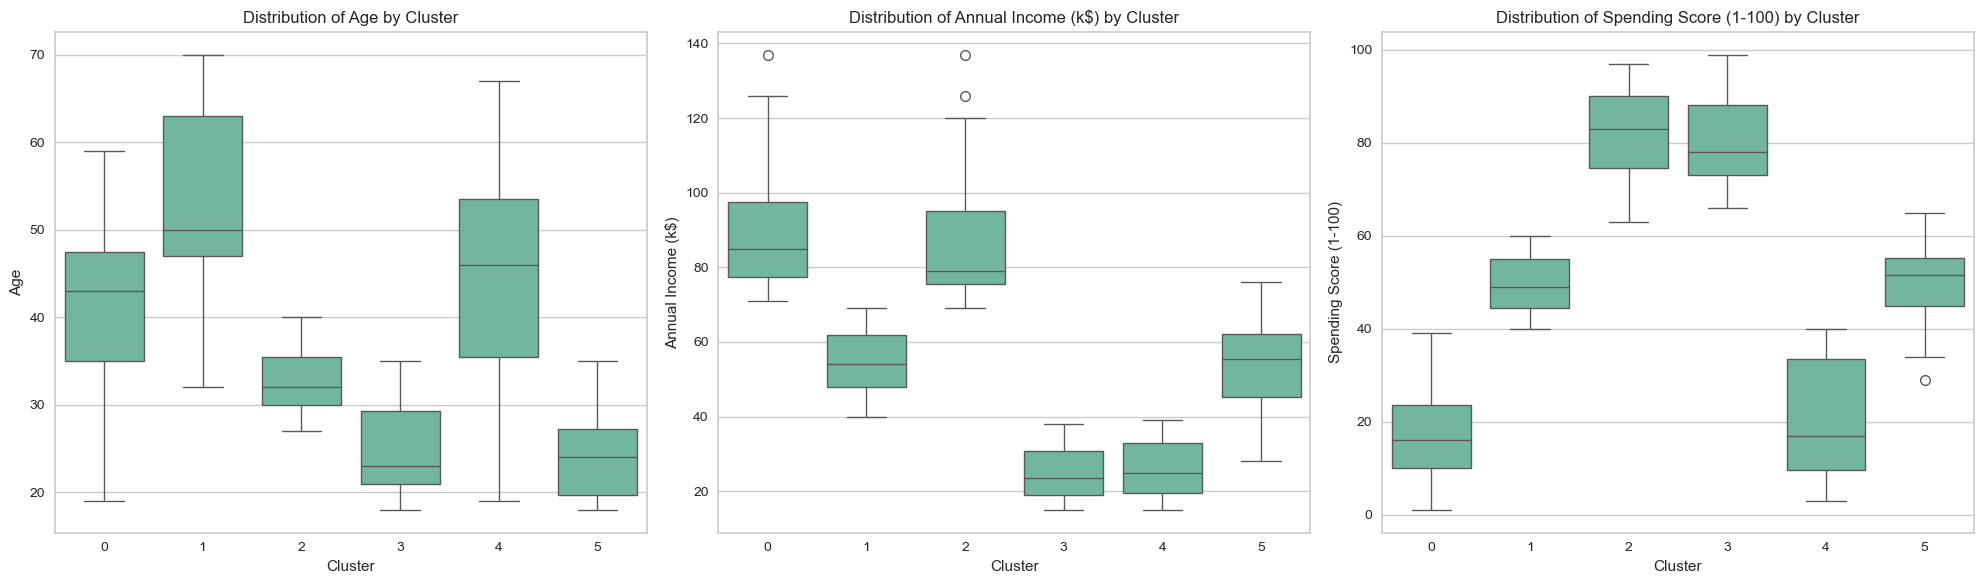

In [181]:
# 각 수치형 변수 별 군집 특징 시각화
df['Cluster'] = agg_pred_6

numeric_cols = ['Age','Annual Income (k$)','Spending Score (1-100)']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Cluster', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Cluster')
plt.tight_layout()
plt.show()

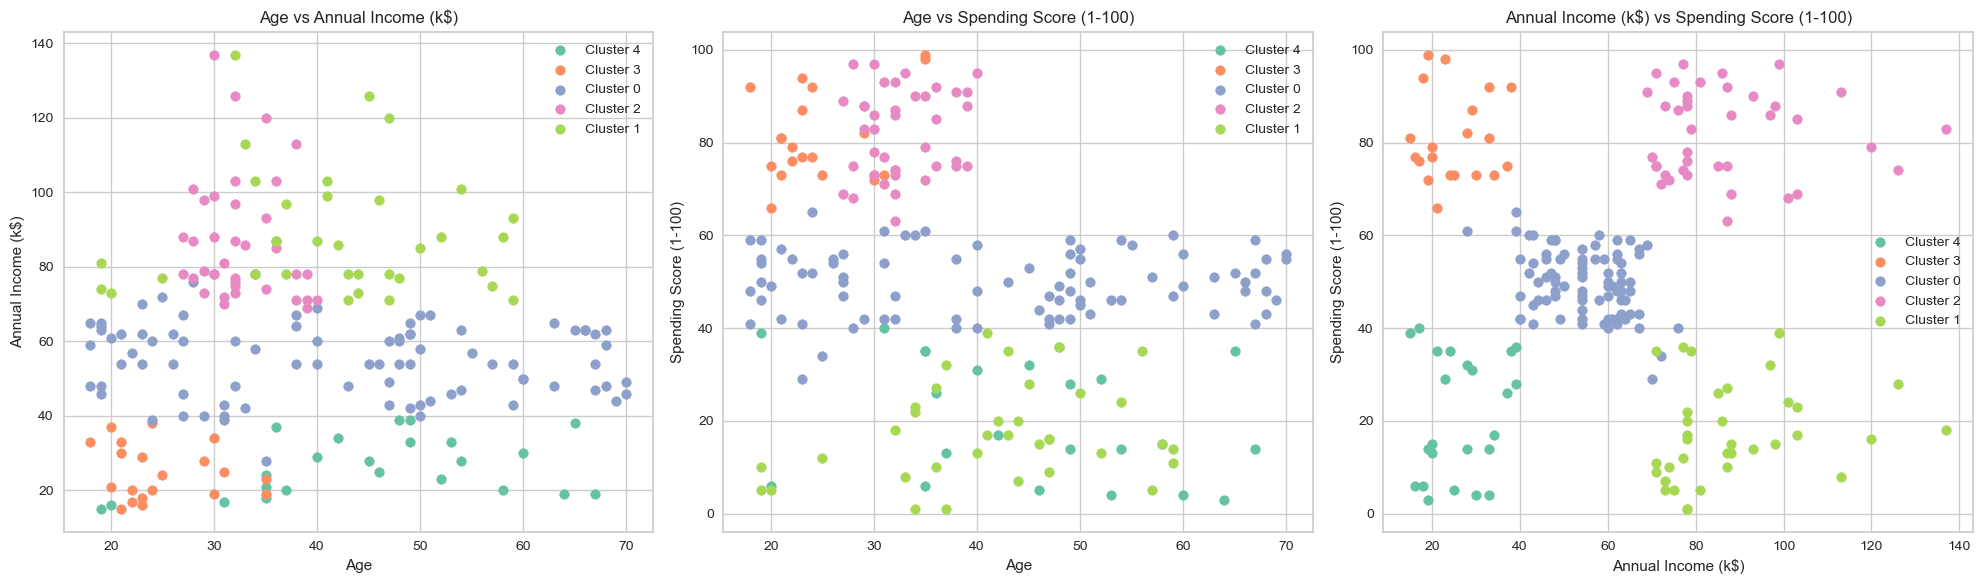

0.4401902591286384

In [218]:
agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
agg_pred_5 = agg.fit_predict(pca_df)

visualization (agg_pred_5)
silhouette_score(pca_df, agg_pred_5)

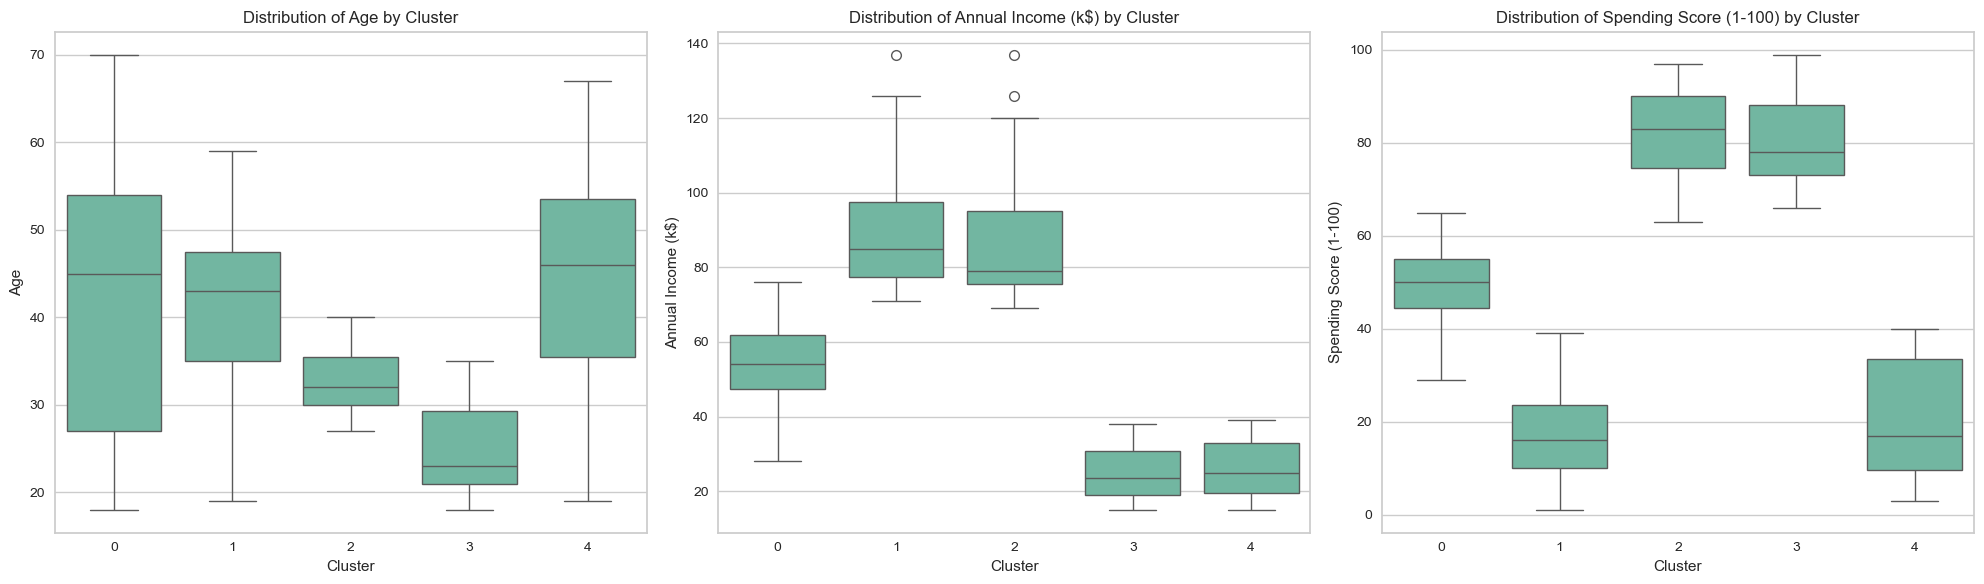

In [219]:
# 각 수치형 변수 별 군집 특징 시각화
df['Cluster'] = agg_pred_5

numeric_cols = ['Age','Annual Income (k$)','Spending Score (1-100)']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Cluster', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Cluster')
plt.tight_layout()
plt.show()

➡️ 실루엣 점수는 클러스터 개수가 6개일 때  약 0.003 정도로 더 높지만, 군집의 특성을 살펴보았을 때 cluster = 5 에서 6으로 변할 때 Age 컬럼에서 정도만 뚜렷한 군집 결과가 나타난 것을 볼 수 있다.

### 2.2 K-means Clustering

In [62]:
!pip install yellowbrick

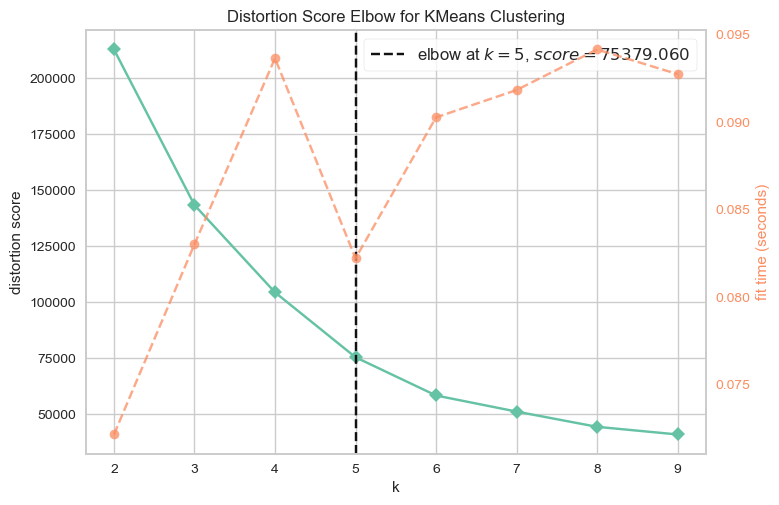

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(2, 10))

In [184]:
# 실루엣 점수
kelbow_visualizer(KMeans(random_state=42), pca_df, k=(2,10))

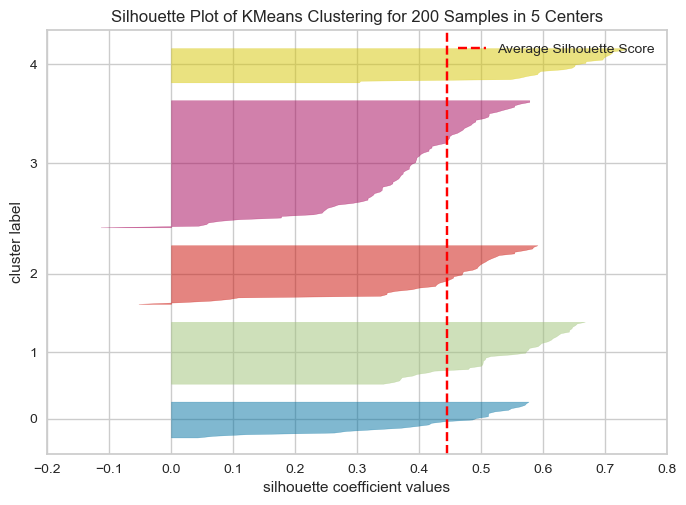

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 200 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, random_state=42))

In [185]:
from yellowbrick.cluster import silhouette_visualizer
silhouette_visualizer(KMeans(5, random_state=42), pca_df, metric = 'silhouette ',colors='yellowbrick')

➡️ 그래프 시각화 결과에 따라 cluster 개수를 5로 설정하여 군집화한다. 이떄, 초기 중심점 설정 기준은 k-means ++ 로 정한다. 클러스터가 서로 겹치지 않고 다양한 영역을 커버할 수 있도록, 초기 중심점으로부터 서로 최대한 멀리 떨어져서 배치시키는 것이 이 알고리즘의 특징이다.

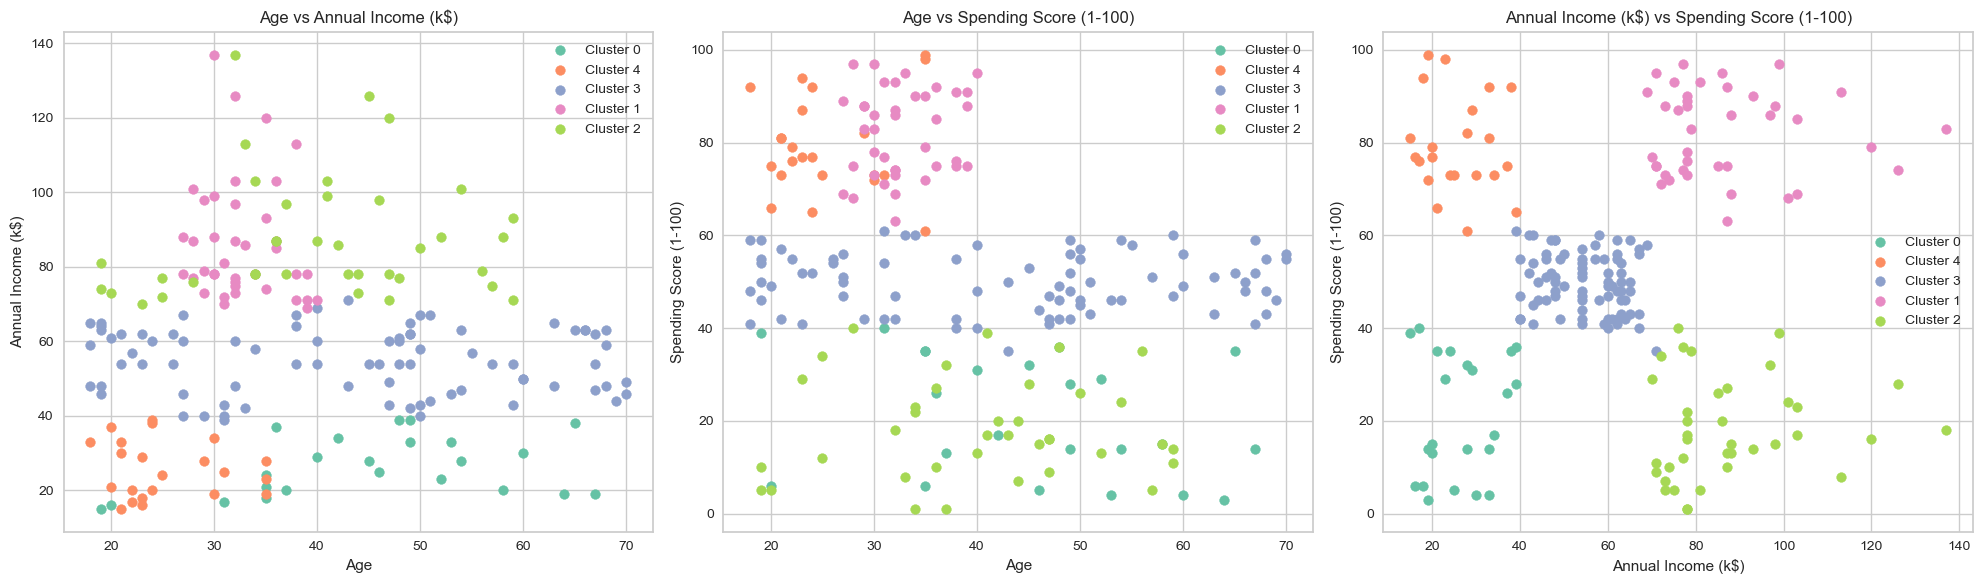

0.44446343179448516

In [194]:
# 시각화 결과
kmeans = KMeans(n_clusters=5,init='k-means++', random_state = 42)
kmeans_pred = kmeans.fit_predict(pca_df)

visualization (kmeans_pred)
silhouette_score(pca_df, kmeans_pred)

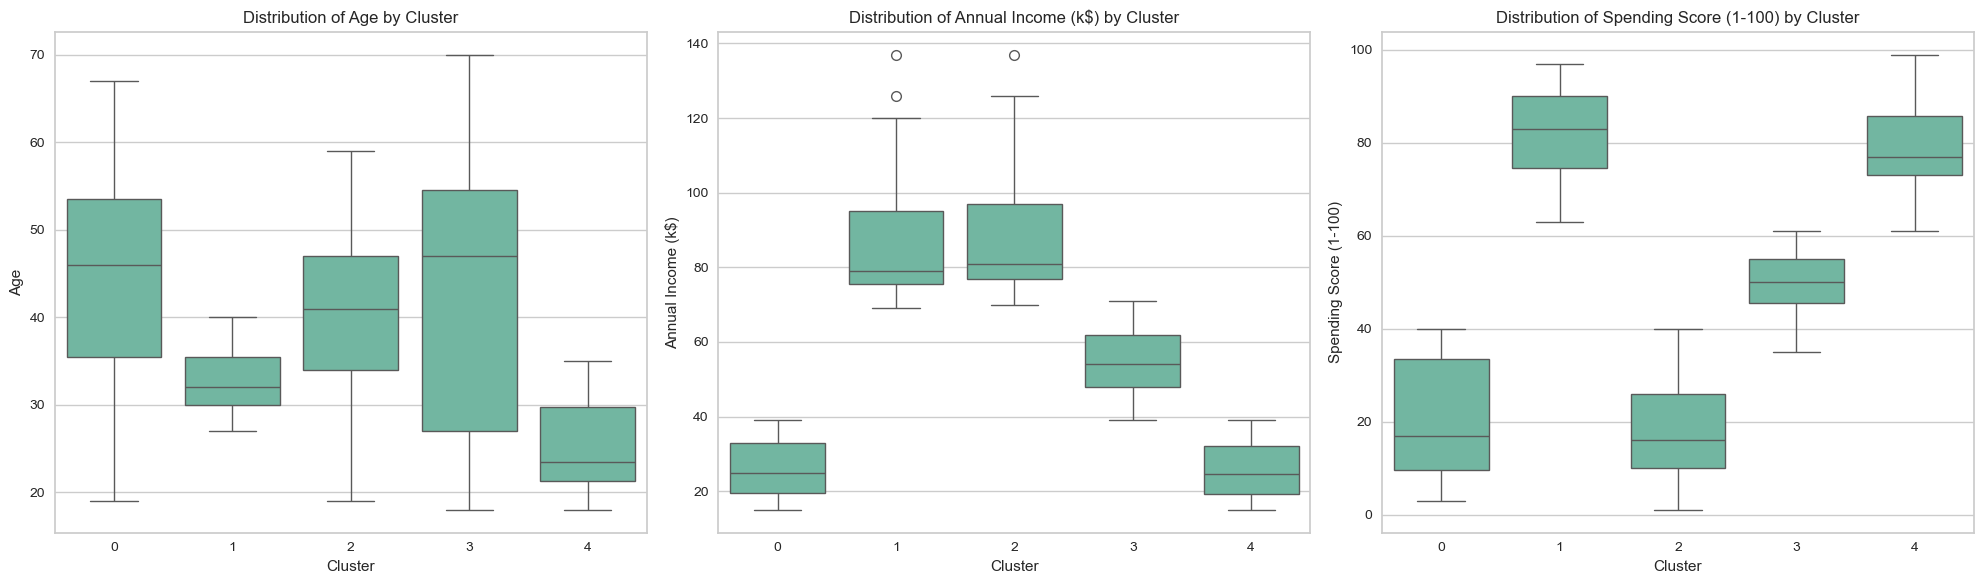

In [195]:
# 각 수치형 변수 별 군집 특징 시각화
df['Cluster'] = kmeans_pred

numeric_cols = ['Age','Annual Income (k$)','Spending Score (1-100)']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Cluster', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Cluster')
plt.tight_layout()
plt.show()

### 2.3 DBSCAN

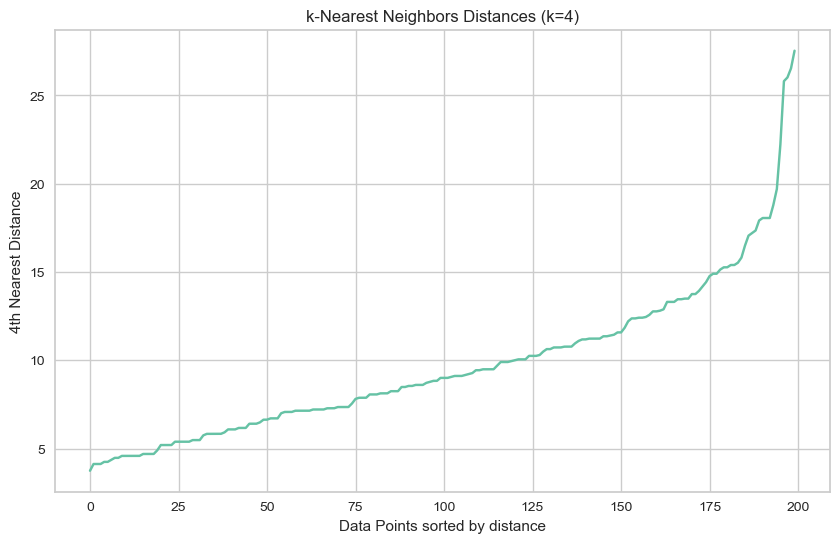

In [197]:
k = 4
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(pca_df)

# 각 데이터 포인트에 대해 k번째 가장 가까운 이웃까지의 거리 계산
distances, indices = neigh.kneighbors(pca_df)

kth_distances = distances[:, k-1]
kth_distances.sort()

plt.figure(figsize=(10, 6))
plt.plot(kth_distances)
plt.title(f'k-Nearest Neighbors Distances (k={k})')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}th Nearest Distance')
plt.show()


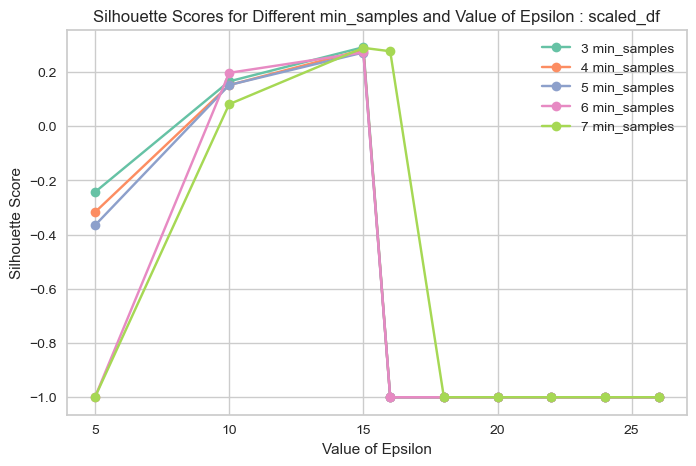

In [207]:
eps_list = [5,10,15,16,18,20,22,24,26]
min_samples_list = [3,4,5,6,7]

silhouette_scores = {method: [] for method in min_samples_list}  

for min_samples in min_samples_list:
    for eps in eps_list:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        db_pred = db.fit_predict(pca_df)

        # 클러스터의 수가 1보다 큰 경우에만 실루엣 점수를 계산합니다.
        num_clusters = len(set(db_pred)) - (1 if -1 in db_pred else 0)
        if num_clusters > 1:
            score = silhouette_score(pca_df, db_pred)
            silhouette_scores[min_samples].append(score)
        else:
            silhouette_scores[min_samples].append(-1)  # 클러스터가 형성되지 않은 경우에는 None을 추가합니다.
        
plt.figure(figsize=(8, 5))
for min_samples, scores in silhouette_scores.items():
    plt.plot(eps_list, scores, marker='o', label=f'{min_samples} min_samples')

plt.title('Silhouette Scores for Different min_samples and Value of Epsilon : scaled_df')
plt.xlabel('Value of Epsilon')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()


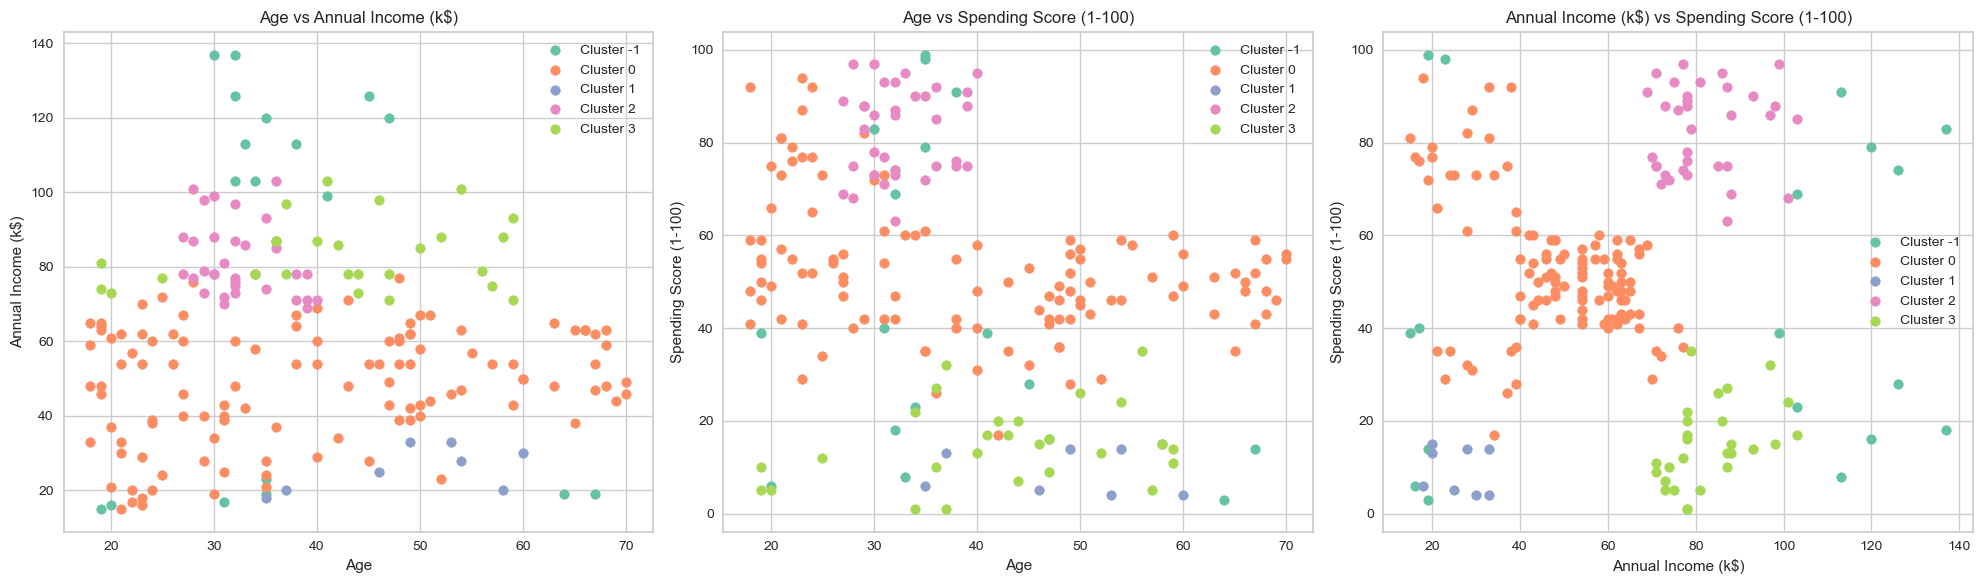

0.28935924821345843

In [208]:
# bset silhouette score
db = DBSCAN(eps=15, min_samples=7)
db_pred = db.fit_predict(pca_df)

visualization (db_pred)
silhouette_score(pca_df, db_pred)

## 3. Evaluation

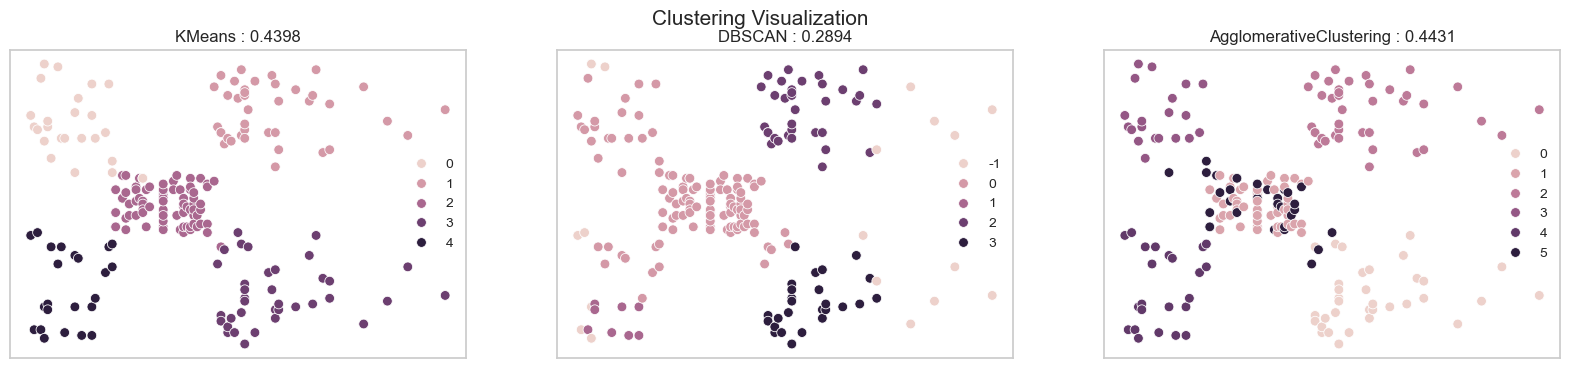

In [220]:
# 최종 결과 시각화 모음 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4), subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle('Clustering Visualization', fontsize=15)

algorithms = [
    KMeans(n_clusters=5, init='k-means++'),
    DBSCAN(eps=15, min_samples=7),
    AgglomerativeClustering(n_clusters=6, linkage= 'ward'),
]

for ax, algorithm in zip(axes.flatten(), algorithms):
    cluster_pred = algorithm.fit_predict(pca_df)
    # 시각화 결과가 가장 눈에 잘 띠는 형태를 가져오기 위해 다음 두 변수를 선정함
    sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=cluster_pred, ax=ax)
    ax.set(title="{} : {:.4f}".format(algorithm.__class__.__name__,
                                      silhouette_score(pca_df, cluster_pred)))
plt.show()

In [210]:
def dunn_index(df, cluster_labels):
    unique_clusters = np.unique(cluster_labels)
    
    # 클러스터가 하나만 있거나 없는 경우 (DBSCAN 대비).
    if len(unique_clusters) <= 1:
        return None
    
    distances = euclidean_distances(df)
    
    # inter-cluster distance의 최소값 
    min_intercluster_distance = np.inf
    for i in unique_clusters:
        for j in unique_clusters:
            if i != j:
                # 클러스터 i와 클러스터 j 사이의 거리 
                cluster_i = df[cluster_labels == i]
                cluster_j = df[cluster_labels == j]
                
                distance = np.min(euclidean_distances(cluster_i, cluster_j))
                if distance < min_intercluster_distance:
                    min_intercluster_distance = distance
                    
    # intra-cluster distance의 최대값
    max_intracluster_distance = 0
    for i in unique_clusters:
        # 클러스터 내의 거리 계산
        cluster_i = df[cluster_labels == i]

        if len(cluster_i) > 1:
            intra_distances = euclidean_distances(cluster_i)
            max_distance = np.max(intra_distances)
            if max_distance > max_intracluster_distance:
                max_intracluster_distance = max_distance
    
    if max_intracluster_distance == 0:
        return None
    else:
        return min_intercluster_distance / max_intracluster_distance

In [221]:
dunn_agg_6 = dunn_index(pca_df, agg_pred_6)
dunn_agg_5 = dunn_index(pca_df, agg_pred_5)

dunn_kmeans = dunn_index(pca_df, kmeans_pred)
dunn_db = dunn_index(pca_df, db_pred)

print(f"Dunn Index of AgglomerativeClustering with 6 clusters : {dunn_agg_6}")
print(f"Dunn Index of AgglomerativeClustering 5 clusters: {dunn_agg_5}")
print(f"Dunn Index of KMeans : {dunn_kmeans}")
print(f"Dunn Index of DBSCAN : {dunn_db}")


Dunn Index of AgglomerativeClustering with 6 clusters : 0.09044753157027043
Dunn Index of AgglomerativeClustering 5 clusters: 0.09044753157027043
Dunn Index of KMeans : 0.09044753157027043
Dunn Index of DBSCAN : 0.031255319582558554


✅ 결과 정리

- 실루엣 계수에 의하면 AgglomerativeClustering 이 가장 최적화된 군집을 생성해냈다고 할 수 있다.
- dunn index는 대체로 매우 낮은 수치를 보이며, 그 중 DBSCAN이 가장 낮다.
- DBSCAN의 실루엣 계수는 약 0.29로, 가장 낮은 수치를 보인다. 주어진 데이터셋은 DBSCAN 알고리즘의 가정에 부합하지 않는 것으로 볼 수 있다 <br>
    1) 임의의 군집은 밀도가 높다<br>
    2) 노이즈 주변의 밀도가 낮다<br>
- AgglomerativeClustering에서 cluster 개수가 5일 때와 6일 때의 dunn index는 같으며, 실루엣 계수의 차이는 0.003으로 매우 작다. 분석 목적에 따라 클러스터 개수를 정하여 적절하게 사용해도 무방할 것으로 보인다